### LSTM Long Short-Term Memory with Pytorch using CPU and GPU


In [1]:
# Import Python Libraries

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
use_cuda = True

In [3]:
# Get the training data set, train=True
# Make sure data is tesnor, transform=transforms.ToTensor()
# download if doesn't exist, download=True
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

In [4]:
# load the testing dataset
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [5]:
batch_size = 100
epochs = 10

In [6]:
accuracy_list = []
epoch_list = []
for i in range(0,epochs):
    epoch_list.append(i)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
isinstance(train_loader, collections.Iterable)

True

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
isinstance(test_loader, collections.Iterable)

True

In [9]:
class LSTMModel(nn.Module):
    def __init__ (self, input_size, hidden_size, layer_number, output_size):
        super(LSTMModel, self).__init__()
        # Set hidden layer input size
        self.hidden_size = hidden_size
        
        # Set number of hidden layer
        self.layer_number = layer_number
        
        # Build LSMT Unit
        # batch_first = True means batch comes first in the new tensor shape
        # so the tensor shape is (batch, seq_number, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, layer_number, batch_first = True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initilize hidden state with 0
        if torch.cuda.is_available() and use_cuda:
            h0 = Variable(torch.zeros(self.layer_number, x.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_number, x.size(0), self.hidden_size))
            
        # Initilize cell
        if torch.cuda.is_available() and use_cuda:
            c0 = Variable(torch.zeros(self.layer_number, x.size(0), self.hidden_size).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_number, x.size(0), self.hidden_size))
            
        # out size 100, 28, 100 (batch, seq_number, hidden_size)
        out, hn = self.lstm(x, (h0,c0))
        
        # only use the last time step of the squence if the FC
        out = self.fc(out[:, -1, :])
        
        return out

In [10]:
input_size = 28
hidden_size = 100
layer_size = 3
output_size = 10

In [11]:
# Create LSTM model instance
model = LSTMModel(input_size, hidden_size, layer_size, output_size)

In [12]:
# Move the model to GPU if CUDA is available an the use_cuda is True
if torch.cuda.is_available() and use_cuda:
    model.cuda()

In [13]:
# Instantiate the cost function
loss_function = nn.CrossEntropyLoss()

In [14]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def calcuateAccuracy():
    correct = 0
    total = 0
        
    for images, labels in test_loader:
        # get all the images in the training data set
        if torch.cuda.is_available() and use_cuda:
            # move torch tensors to the GPU
            images = Variable(images.view(-1, seq_number, input_size).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_number, input_size))
            labels = Variable(labels)
        
        # get all the predictions for each class using the model
        all_predictions = model(images)
            
        # highest is the final prediction
        _, predictions = torch.max(all_predictions.data, 1)
       
        # total number of samples
        total = total + labels.size(0)
            
        # corrrect prediction
        # compare prediction with labels element wise
        # sum returned tensor (it has True/1 or False/0 in it)
        if torch.cuda.is_available() and use_cuda:
            correct = correct + (predictions.cpu() == labels.cpu()).sum()
        else:
            correct = correct + (predictions == labels).sum()
        
        correct_np = correct.numpy()
            
    accuracy = 100 * correct_np / total;
    print("accuracy: " + str(accuracy))
    return accuracy

In [16]:
seq_number = 28

def train():
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            # get a batch of images and labels
            if torch.cuda.is_available() and use_cuda:
                #move torch tensors to the GPU
                images = Variable(images.view(-1, seq_number, input_size).cuda())
                labels = Variable(labels.cuda())
            else:
                images = Variable(images.view(-1, seq_number, input_size))
                labels = Variable(labels)

            # set gradients to 0
            optimizer.zero_grad()

            # get predictions for the batch
            predictions = model(images)

            # calculate loss
            loss = loss_function(predictions, labels)

            # calculate the gradients
            loss.backward()

            # update the weights
            optimizer.step()

        accuracy = calcuateAccuracy()
        accuracy_list.append(accuracy)

In [17]:
def plot():
    plt.clf()
    plt.plot(epoch_list, accuracy_list, '-', alpha=0.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.xticks(epoch_list) 
    plt.yticks(np.arange(min(accuracy_list)-min(accuracy_list)%5, max(accuracy_list), 5)) 
    plt.show()

In [18]:
train()

accuracy: 10.1
accuracy: 18.37
accuracy: 64.05
accuracy: 82.41
accuracy: 91.7
accuracy: 94.43
accuracy: 95.09
accuracy: 95.29
accuracy: 97.24
accuracy: 97.16


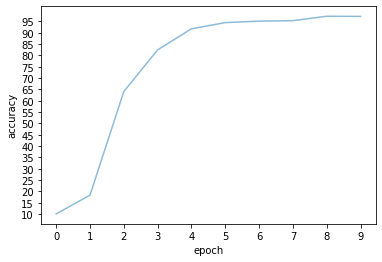

In [19]:
plot()

In [20]:
# model.load_state_dict(torch.load("lstm_model.pkl"))
torch.save(model.state_dict(), 'lstm_model.pkl')